# Основы Lasagne MLP

In [1]:
import numpy as np
import theano
import theano.tensor as T

http://deeplearning.net/software/theano/

In [2]:
import lasagne

http://lasagne.readthedocs.io/en/latest/

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

http://matplotlib.org/gallery.html

In [4]:
import gzip
import pickle

https://docs.python.org/2/library/gzip.html

https://docs.python.org/2/library/pickle.html

## Скачиваем набор данных MNIST

In [5]:
!wget -N http://deeplearning.net/data/mnist/mnist.pkl.gz

--2016-11-23 12:02:30--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘mnist.pkl.gz’ not modified on server. Omitting download.



## Загружаем данные

In [6]:
train, val, test = pickle.load(gzip.open('mnist.pkl.gz'))

X_train, y_train = train
X_val, y_val = val

## Визуализируем цифры

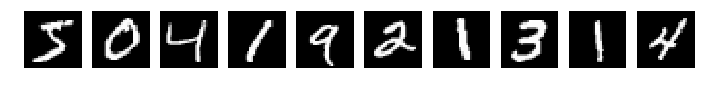

In [7]:
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape((28, 28)), cmap='gray', interpolation='nearest')
    plt.axis('off')

## Создаём функцию генерации минибатчей

In [8]:
def batch_gen(X, y, N):
    while True:
        idx = np.random.choice(len(y), N)
        yield X[idx].astype('float32'), y[idx].astype('int32')

## Собираем простую нейросеть

In [9]:
l_in = lasagne.layers.InputLayer((None, 784))
l_out = lasagne.layers.DenseLayer(
    l_in,
    num_units=10,
    nonlinearity=lasagne.nonlinearities.softmax)

### Символьные переменные для признаков и меток

In [10]:
X_sym = T.matrix()
y_sym = T.ivector()

### Получаем предсказание модели

In [11]:
output = lasagne.layers.get_output(l_out, X_sym)
pred = output.argmax(-1)

In [12]:
print("Output type: {}".format(type(output)))
print("Pred type: {}".format(type(pred)))

Output type: <class 'theano.tensor.var.TensorVariable'>
Pred type: <class 'theano.tensor.var.TensorVariable'>


## Определяем целевую функцию

In [13]:
loss = T.mean(lasagne.objectives.categorical_crossentropy(output, y_sym))
acc = T.mean(T.eq(pred, y_sym))

## Какие же параметры имеет нейросеть?

In [14]:
params = lasagne.layers.get_all_params(l_out)
print(params)

[W, b]


## Находим производные функции потерь по все параметрам модели

In [15]:
grad = T.grad(loss, params)

## В качестве метода оптимизации выбираем SGD с LL = 0.05

In [16]:
updates = lasagne.updates.sgd(grad, params, learning_rate=0.05)

### Создаём функцию обучения

In [17]:
f_train = theano.function([X_sym, y_sym], [loss, acc], updates=updates)

### Создаём функцию валидации

In [18]:
f_val = theano.function([X_sym, y_sym], [loss, acc])

### Создаём функцию получения предсказания модели

In [19]:
f_predict = theano.function([X_sym], pred)

## Устанавливаем параметры обучения модели для каждой эпохи

In [20]:
BATCH_SIZE = 64
N_BATCHES = len(X_train) // BATCH_SIZE
N_VAL_BATCHES = len(X_val) // BATCH_SIZE

### Создаём минибатчи для обучения и валидации

In [21]:
train_batches = batch_gen(X_train, y_train, BATCH_SIZE)
val_batches = batch_gen(X_val, y_val, BATCH_SIZE)

### Визуализируем число из минибатча

4


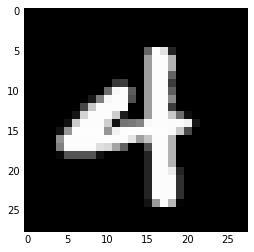

In [22]:
X, y = next(train_batches)
plt.imshow(X[0].reshape((28, 28)), cmap='gray', interpolation='nearest')
print(y[0])

# Обучение модели

In [23]:
for epoch in range(10):
    train_loss = 0
    train_acc = 0
    for _ in range(N_BATCHES):
        X, y = next(train_batches)
        loss, acc = f_train(X, y)
        train_loss += loss
        train_acc += acc
    train_loss /= N_BATCHES
    train_acc /= N_BATCHES

    val_loss = 0
    val_acc = 0
    for _ in range(N_VAL_BATCHES):
        X, y = next(val_batches)
        loss, acc = f_val(X, y)
        val_loss += loss
        val_acc += acc
    val_loss /= N_VAL_BATCHES
    val_acc /= N_VAL_BATCHES
    
    print('Epoch {}, Train (val) loss {:.03f} ({:.03f}) ratio {:.03f}'.format(
            epoch, train_loss, val_loss, val_loss/train_loss))
    print('Train (val) accuracy {:.03f} ({:.03f})'.format(train_acc, val_acc))

Epoch 0, Train (val) loss 0.624 (0.395) ratio 0.632
Train (val) accuracy 0.844 (0.897)
Epoch 1, Train (val) loss 0.387 (0.350) ratio 0.903
Train (val) accuracy 0.893 (0.904)
Epoch 2, Train (val) loss 0.353 (0.318) ratio 0.900
Train (val) accuracy 0.901 (0.910)
Epoch 3, Train (val) loss 0.338 (0.300) ratio 0.889
Train (val) accuracy 0.907 (0.918)
Epoch 4, Train (val) loss 0.328 (0.303) ratio 0.924
Train (val) accuracy 0.909 (0.915)
Epoch 5, Train (val) loss 0.319 (0.289) ratio 0.906
Train (val) accuracy 0.911 (0.917)
Epoch 6, Train (val) loss 0.318 (0.296) ratio 0.934
Train (val) accuracy 0.911 (0.919)
Epoch 7, Train (val) loss 0.301 (0.306) ratio 1.015
Train (val) accuracy 0.915 (0.915)
Epoch 8, Train (val) loss 0.304 (0.287) ratio 0.943
Train (val) accuracy 0.915 (0.918)
Epoch 9, Train (val) loss 0.291 (0.274) ratio 0.941
Train (val) accuracy 0.919 (0.927)


## Получаем параметры модели

In [24]:
weights = l_out.W.get_value()
print(weights.shape)

(784, 10)


## Визуализируем веса модели

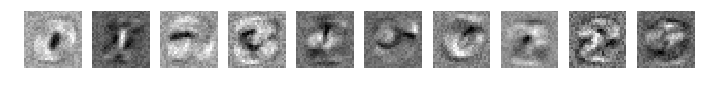

In [25]:
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(weights[:,i].reshape((28, 28)), cmap='gray', interpolation='nearest')
    plt.axis('off')